In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
words = open('../names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)



In [6]:
# Parameters
block_size = 3
batch_size = 32
n_embd = 10  # the dimensionality of the character embedding
n_hidden = 200

g  = torch.Generator().manual_seed(1337)
C  = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g)
b1 = torch.randn((n_hidden),                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn((vocab_size),                      generator=g)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [4]:
# build the dataset

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for chr in w + '.':
            ix = stoi[chr]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.size(), Y.size())
    return X, Y

random.seed(1337)
random.shuffle(words)
n1 = int(len(words)* 0.8)
n2 = int(len(words)* 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182552, 3]) torch.Size([182552])
torch.Size([22737, 3]) torch.Size([22737])
torch.Size([22857, 3]) torch.Size([22857])


In [12]:
# Optimization
max_steps = 2000
lossi = []
for step in range(max_steps):

    # minibatch
    b_ix = torch.randint(0, Xtr.size(0), (batch_size,), generator=g)
    Xb, Yb = Xtr[b_ix], Ytr[b_ix]

    # forward pass
    emb= C[Xb]
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1

    ## batchnorm
    bnmeani = hpreact.mean(0, keepdim=True)  # for perfomance evaluation
    bnstdi = hpreact.std(0, keepdim=True) # for perfomance evaluation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non linearlity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = 0.1 if step < 10000 else 0.01
    for p in parameters:
        if p.grad is not None:
            p.data += -lr * p.grad
    
    # track stats
    if step % 1000 == 0:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f} :lr={lr}")
    lossi.append(loss.log10().item())

      0/   2000: 3.1708 :lr=0.1
   1000/   2000: 2.3381 :lr=0.1


Text(0.5, 1.0, 'before activation function')

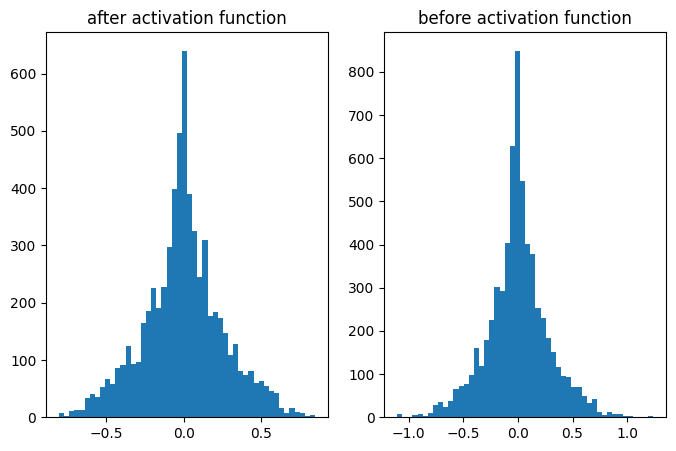

In [30]:
# after activation output
fig, axs = plt.subplots(1, 2, figsize=(8,5))  # 1 row, 2 columns
axs[0].hist(h.view(-1).tolist(),50);
axs[0].set_title("after activation function")
axs[1].hist(hpreact.view(-1).tolist(),50);
axs[1].set_title("before activation function")


Text(0.5, 1.0, 'lossi')

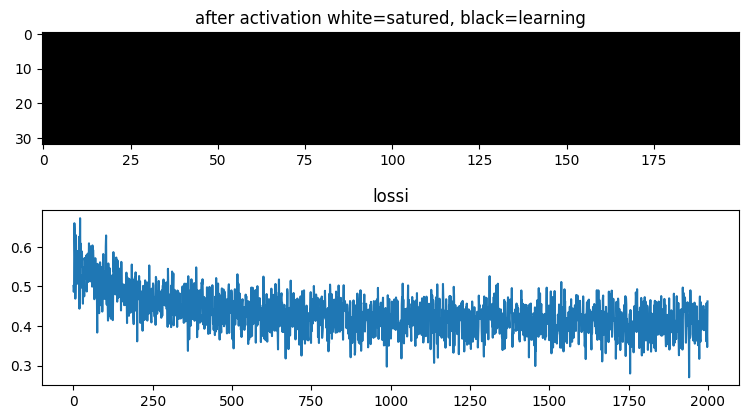

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(9,5))  # 1 row, 2 columns
axs[0].imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
axs[0].set_title("after activation white=satured, black=learning")
axs[1].plot(lossi)
axs[1].set_title("lossi")